<a href="https://colab.research.google.com/github/AaravAttre/APCSP/blob/main/Production_OpenEXA_TimesFM_FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timesfm[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
"""
TimesFM Finetuner: A flexible framework for finetuning TimesFM models on custom datasets.
"""

import logging
import os
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Any, Callable, Dict, List, Optional

import torch
import torch.distributed as dist
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, Dataset
from timesfm.pytorch_patched_decoder import create_quantiles

import wandb


class MetricsLogger(ABC):
  """Abstract base class for logging metrics during training.

    This class defines the interface for logging metrics during model training.
    Concrete implementations can log to different backends (e.g., WandB, TensorBoard).
    """

  @abstractmethod
  def log_metrics(self,
                  metrics: Dict[str, Any],
                  step: Optional[int] = None) -> None:
    """Log metrics to the specified backend.

        Args:
          metrics: Dictionary containing metric names and values.
          step: Optional step number or epoch for the metrics.
        """
    pass

  @abstractmethod
  def close(self) -> None:
    """Clean up any resources used by the logger."""
    pass


class WandBLogger(MetricsLogger):
  """Weights & Biases implementation of metrics logging.

    Args:
      project: Name of the W&B project.
      config: Configuration dictionary to log.
      rank: Process rank in distributed training.
    """

  def __init__(self, project: str, config: Dict[str, Any], rank: int = 0):
    self.rank = rank
    if rank == 0:
      wandb.init(project=project, config=config)

  def log_metrics(self,
                  metrics: Dict[str, Any],
                  step: Optional[int] = None) -> None:
    """Log metrics to W&B if on the main process.

        Args:
          metrics: Dictionary of metrics to log.
          step: Current training step or epoch.
        """
    if self.rank == 0:
      wandb.log(metrics, step=step)

  def close(self) -> None:
    """Finish the W&B run if on the main process."""
    if self.rank == 0:
      wandb.finish()


class DistributedManager:
  """Manages distributed training setup and cleanup.

    Args:
      world_size: Total number of processes.
      rank: Process rank.
      master_addr: Address of the master process.
      master_port: Port for distributed communication.
      backend: PyTorch distributed backend to use.
    """

  def __init__(
      self,
      world_size: int,
      rank: int,
      master_addr: str = "localhost",
      master_port: str = "12358",
      backend: str = "nccl",
  ):
    self.world_size = world_size
    self.rank = rank
    self.master_addr = master_addr
    self.master_port = master_port
    self.backend = backend

  def setup(self) -> None:
    """Initialize the distributed environment."""
    os.environ["MASTER_ADDR"] = self.master_addr
    os.environ["MASTER_PORT"] = self.master_port

    if not dist.is_initialized():
      dist.init_process_group(backend=self.backend,
                              world_size=self.world_size,
                              rank=self.rank)

  def cleanup(self) -> None:
    """Clean up the distributed environment."""
    if dist.is_initialized():
      dist.destroy_process_group()


@dataclass
class FinetuningConfig:
  """Configuration for model training.

    Args:
      batch_size: Number of samples per batch.
      num_epochs: Number of training epochs.
      learning_rate: Initial learning rate.
      weight_decay: L2 regularization factor.
      freq_type: Frequency, can be [0, 1, 2].
      use_quantile_loss: bool = False  # Flag to enable/disable quantile loss
      quantiles: Optional[List[float]] = None
      device: Device to train on ('cuda' or 'cpu').
      distributed: Whether to use distributed training.
      gpu_ids: List of GPU IDs to use.
      master_port: Port for distributed training.
      master_addr: Address for distributed training.
      use_wandb: Whether to use Weights & Biases logging.
      wandb_project: W&B project name.
      log_every_n_steps: Log metrics every N steps (batches), this is inspired from Pytorch Lightning
      val_check_interval: How often within one training epoch to check val metrics. (also from Pytorch Lightning)
        Can be: float (0.0-1.0): fraction of epoch (e.g., 0.5 = validate twice per epoch)
                int: validate every N batches
    """

  batch_size: int = 32
  num_epochs: int = 20
  learning_rate: float = 1e-4
  weight_decay: float = 0.01
  freq_type: int = 0
  use_quantile_loss: bool = False
  quantiles: Optional[List[float]] = None
  device: str = "cuda" if torch.cuda.is_available() else "cpu"
  distributed: bool = False
  gpu_ids: List[int] = field(default_factory=lambda: [0])
  master_port: str = "12358"
  master_addr: str = "localhost"
  use_wandb: bool = False
  wandb_project: str = "timesfm-finetuning"
  log_every_n_steps: int = 50
  val_check_interval: float = 0.5


class TimesFMFinetuner:
  """Handles model training and validation.

    Args:
      model: PyTorch model to train.
      config: Training configuration.
      rank: Process rank for distributed training.
      loss_fn: Loss function (defaults to MSE).
      logger: Optional logging.Logger instance.
    """

  def __init__(
      self,
      model: nn.Module,
      config: FinetuningConfig,
      rank: int = 0,
      loss_fn: Optional[Callable] = None,
      logger: Optional[logging.Logger] = None,
  ):
    self.model = model
    self.config = config
    self.rank = rank
    self.logger = logger or logging.getLogger(__name__)
    self.device = torch.device(
        f"cuda:{rank}" if torch.cuda.is_available() else "cpu")
    self.loss_fn = loss_fn or (lambda x, y: torch.mean((x - y.squeeze(-1))**2))

    if config.use_wandb:
      self.metrics_logger = WandBLogger(config.wandb_project, config.__dict__,
                                        rank)

    if config.distributed:
      self.dist_manager = DistributedManager(
          world_size=len(config.gpu_ids),
          rank=rank,
          master_addr=config.master_addr,
          master_port=config.master_port,
      )
      self.dist_manager.setup()
      self.model = self._setup_distributed_model()

  def _setup_distributed_model(self) -> nn.Module:
    """Configure model for distributed training."""
    self.model = self.model.to(self.device)
    return DDP(self.model,
               device_ids=[self.config.gpu_ids[self.rank]],
               output_device=self.config.gpu_ids[self.rank])

  def _create_dataloader(self, dataset: Dataset, is_train: bool) -> DataLoader:
    """Create appropriate DataLoader based on training configuration.

        Args:
          dataset: Dataset to create loader for.
          is_train: Whether this is for training (affects shuffling).

        Returns:
          DataLoader instance.
        """
    if self.config.distributed:
      sampler = torch.utils.data.distributed.DistributedSampler(
          dataset,
          num_replicas=len(self.config.gpu_ids),
          rank=dist.get_rank(),
          shuffle=is_train)
    else:
      sampler = None

    return DataLoader(
        dataset,
        batch_size=self.config.batch_size,
        shuffle=(is_train and not self.config.distributed),
        sampler=sampler,
    )

  def _quantile_loss(self, pred: torch.Tensor, actual: torch.Tensor,
                     quantile: float) -> torch.Tensor:
    """Calculates quantile loss.
        Args:
            pred: Predicted values
            actual: Actual values
            quantile: Quantile at which loss is computed
        Returns:
            Quantile loss
        """
    dev = actual - pred
    loss_first = dev * quantile
    loss_second = -dev * (1.0 - quantile)
    return 2 * torch.where(loss_first >= 0, loss_first, loss_second)

  def _process_batch(self, batch: List[torch.Tensor]) -> tuple:
    """Process a single batch of data.

        Args:
          batch: List of input tensors.

        Returns:
          Tuple of (loss, predictions).
        """
    x_context, x_padding, freq, x_future = [
        t.to(self.device, non_blocking=True) for t in batch
    ]

    predictions = self.model(x_context, x_padding.float(), freq)
    predictions_mean = predictions[..., 0]
    last_patch_pred = predictions_mean[:, -1, :]

    loss = self.loss_fn(last_patch_pred, x_future.squeeze(-1))
    if self.config.use_quantile_loss:
      quantiles = self.config.quantiles or create_quantiles()
      for i, quantile in enumerate(quantiles):
        last_patch_quantile = predictions[:, -1, :, i + 1]
        loss += torch.mean(
            self._quantile_loss(last_patch_quantile, x_future.squeeze(-1),
                                quantile))

    return loss, predictions

  def _train_epoch(self, train_loader: DataLoader,
                   optimizer: torch.optim.Optimizer) -> float:
    """Train for one epoch in a distributed setting.

        Args:
            train_loader: DataLoader for training data.
            optimizer: Optimizer instance.

        Returns:
            Average training loss for the epoch.
        """
    self.model.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    for batch in train_loader:
      loss, _ = self._process_batch(batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avg_loss = total_loss / num_batches

    if self.config.distributed:
      avg_loss_tensor = torch.tensor(avg_loss, device=self.device)
      dist.all_reduce(avg_loss_tensor, op=dist.ReduceOp.SUM)
      avg_loss = (avg_loss_tensor / dist.get_world_size()).item()

    return avg_loss

  def _validate(self, val_loader: DataLoader) -> float:
    """Perform validation.

        Args:
            val_loader: DataLoader for validation data.

        Returns:
            Average validation loss.
        """
    self.model.eval()
    total_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
      for batch in val_loader:
        loss, _ = self._process_batch(batch)
        total_loss += loss.item()

    avg_loss = total_loss / num_batches

    if self.config.distributed:
      avg_loss_tensor = torch.tensor(avg_loss, device=self.device)
      dist.all_reduce(avg_loss_tensor, op=dist.ReduceOp.SUM)
      avg_loss = (avg_loss_tensor / dist.get_world_size()).item()

    return avg_loss

  def finetune(self, train_dataset: Dataset,
               val_dataset: Dataset) -> Dict[str, Any]:
    """Train the model.

        Args:
          train_dataset: Training dataset.
          val_dataset: Validation dataset.

        Returns:
          Dictionary containing training history.
        """
    self.model = self.model.to(self.device)
    train_loader = self._create_dataloader(train_dataset, is_train=True)
    val_loader = self._create_dataloader(val_dataset, is_train=False)

    optimizer = torch.optim.Adam(self.model.parameters(),
                                 lr=self.config.learning_rate,
                                 weight_decay=self.config.weight_decay)

    history = {"train_loss": [], "val_loss": [], "learning_rate": []}

    self.logger.info(
        f"Starting training for {self.config.num_epochs} epochs...")
    self.logger.info(f"Training samples: {len(train_dataset)}")
    self.logger.info(f"Validation samples: {len(val_dataset)}")

    try:
      for epoch in range(self.config.num_epochs):
        train_loss = self._train_epoch(train_loader, optimizer)
        val_loss = 0
        current_lr = optimizer.param_groups[0]["lr"]

        metrics = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": current_lr,
            "epoch": epoch + 1,
        }

        if self.config.use_wandb:
          self.metrics_logger.log_metrics(metrics)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rate"].append(current_lr)

        if self.rank == 0:
          self.logger.info(
              f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
          )

    except KeyboardInterrupt:
      self.logger.info("Training interrupted by user")

    if self.config.distributed:
      self.dist_manager.cleanup()

    if self.config.use_wandb:
      self.metrics_logger.close()

    return {"history": history}

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].


In [ ]:
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
#from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os


class TimeSeriesDataset(Dataset):
  """Dataset for time series data compatible with TimesFM."""

  def __init__(self,
               series: np.ndarray,
               context_length: int,
               horizon_length: int,
               freq_type: int = 0):
    """
        Initialize dataset.

        Args:
            series: Time series data
            context_length: Number of past timesteps to use as input
            horizon_length: Number of future timesteps to predict
            freq_type: Frequency type (0, 1, or 2)
        """
    if freq_type not in [0, 1, 2]:
      raise ValueError("freq_type must be 0, 1, or 2")

    self.series = series
    self.context_length = context_length
    self.horizon_length = horizon_length
    self.freq_type = freq_type
    self._prepare_samples()

  def _prepare_samples(self) -> None:
    """Prepare sliding window samples from the time series."""
    self.samples = []
    total_length = self.context_length + self.horizon_length

    for start_idx in range(0, len(self.series) - total_length + 1):
      end_idx = start_idx + self.context_length
      x_context = self.series[start_idx:end_idx]
      x_future = self.series[end_idx:end_idx + self.horizon_length]
      self.samples.append((x_context, x_future))

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(
      self, index: int
  ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    x_context, x_future = self.samples[index]

    x_context = torch.tensor(x_context, dtype=torch.float32)
    x_future = torch.tensor(x_future, dtype=torch.float32)

    input_padding = torch.zeros_like(x_context)
    freq = torch.tensor([self.freq_type], dtype=torch.long)

    return x_context, input_padding, freq, x_future

def prepare_datasets(series: np.ndarray,
                     context_length: int,
                     horizon_length: int,
                     freq_type: int = 0,
                     train_split: float = 0.8) -> Tuple[Dataset, Dataset]:
  """
    Prepare training and validation datasets from time series data.

    Args:
        series: Input time series data
        context_length: Number of past timesteps to use
        horizon_length: Number of future timesteps to predict
        freq_type: Frequency type (0, 1, or 2)
        train_split: Fraction of data to use for training

    Returns:
        Tuple of (train_dataset, val_dataset)
    """

  print('using context length', context_length)
  print('using horizon length', horizon_length)
  train_size = int(len(series) * train_split)
  train_data = series[:train_size]
  val_data = series[train_size:]

  print('train data length', len(train_data))
  print('val data length', len(val_data))

  # Create datasets with specified frequency type
  train_dataset = TimeSeriesDataset(train_data,
                                    context_length=context_length,
                                    horizon_length=horizon_length,
                                    freq_type=freq_type)

  val_dataset = TimeSeriesDataset(val_data,
                                  context_length=context_length,
                                  horizon_length=horizon_length,
                                  freq_type=freq_type)

  return train_dataset, val_dataset

In [ ]:
def get_model(load_weights: bool = False):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=128,
      num_layers=50,
      use_positional_embedding=False,
      context_len=
      160,  # Context length can be anything up to 2048 in multiples of 32
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))
  print('TFM HRZ LEN', tfm.horizon_len)
  model = PatchedTimeSeriesDecoder(tfm._model_config)

  print('MODEL HRZ LEN', tfm._model_config.horizon_len)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

In [ ]:
def plot_predictions(
    model: TimesFm,
    val_dataset: Dataset,
    save_path: Optional[str] = "predictions.png",
) -> None:
  """
    Plot model predictions against ground truth for a batch of validation data.

    Args:
      model: Trained TimesFM model
      val_dataset: Validation dataset
      save_path: Path to save the plot
    """
  import matplotlib.pyplot as plt

  model.eval()

  x_context, x_padding, freq, x_future = val_dataset[0]
  x_context = x_context.unsqueeze(0)  # Add batch dimension
  x_padding = x_padding.unsqueeze(0)
  freq = freq.unsqueeze(0)
  x_future = x_future.unsqueeze(0)

  device = next(model.parameters()).device
  x_context = x_context.to(device)
  x_padding = x_padding.to(device)
  freq = freq.to(device)
  x_future = x_future.to(device)

  with torch.no_grad():
    predictions = model(x_context, x_padding.float(), freq)
    predictions_mean = predictions[..., 0]  # [B, N, horizon_len]
    last_patch_pred = predictions_mean[:, -1, :]  # [B, horizon_len]

  context_vals = x_context[0].cpu().numpy()
  future_vals = x_future[0].cpu().numpy()
  pred_vals = last_patch_pred[0].cpu().numpy()

  context_len = len(context_vals)
  horizon_len = len(future_vals)

  plt.figure(figsize=(12, 6))

  plt.plot(range(context_len),
           context_vals,
           label="Historical Data",
           color="blue",
           linewidth=2)

  plt.plot(
      range(context_len, context_len + horizon_len),
      future_vals,
      label="Ground Truth",
      color="green",
      linestyle="--",
      linewidth=2,
  )

  print(pred_vals)
  print(len(pred_vals))

  plt.plot(range(context_len, context_len + horizon_len),
           pred_vals,
           label="Prediction",
           color="red",
           linewidth=2)

  plt.xlabel("Time Step")
  plt.ylabel("Value")
  plt.title("TimesFM Predictions vs Ground Truth")
  plt.legend()
  plt.grid(True)

  if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

  plt.close()

# Edit Below!

In [ ]:
import pandas as pd
from pandas import DataFrame, Series

import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

CONFIG = {
    'data_url': 'drive/MyDrive/gbtc_daily.csv',
    'date_col': 'Date',
    'price_col': 'Price',
    'batch_size': 256,
    'num_epochs': 10,
    'learning_rate': 0.00005,
    'train_split': 0.5,
    'context_length': 128,
    'freq_type': 1,
    'days_to_predict': 15,
    'data_reserve': 1
}


def getDataFrame() -> DataFrame:
    dataset = pd.read_csv(CONFIG['data_url'], parse_dates=[CONFIG['date_col']], index_col=CONFIG['date_col']).sort_index()
    return dataset


def getPrice(dataframe: DataFrame) -> Series:
    return dataframe[CONFIG['price_col']]

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

df = getDataFrame()

def get_data(context_len: int, horizon_len: int, freq_type: int = 0):
    time_series = getPrice(df).values[:-128].reshape(-1, 1)

    train_dataset, val_dataset = prepare_datasets(
        series=time_series,
        context_length=context_len,
        horizon_length=horizon_len,
        freq_type=freq_type,
        train_split=CONFIG['train_split'],
    )

    return train_dataset, val_dataset

def single_gpu_example():
    model, hparams, tfm_config = get_model(load_weights=True)
    config = FinetuningConfig(
        batch_size=CONFIG['batch_size'],
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate'],
        use_wandb=True,
        freq_type=CONFIG['freq_type'],
        log_every_n_steps=1,
        val_check_interval=0.5,
        use_quantile_loss=True
    )

    train_dataset, val_dataset = get_data(
        CONFIG['context_length'],
        tfm_config.horizon_len,
        freq_type=config.freq_type
    )
    finetuner = TimesFMFinetuner(model, config)

    results = finetuner.finetune(train_dataset=train_dataset, val_dataset=val_dataset)
    return model

MODEL = single_gpu_example()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

TFM HRZ LEN 128
MODEL HRZ LEN 128


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

using context length 128
using horizon length 128
train data length 383
val data length 383


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,▆▃▄▃█▃▂▂▂▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
learning_rate,5e-05
train_loss,11.12379
val_loss,0


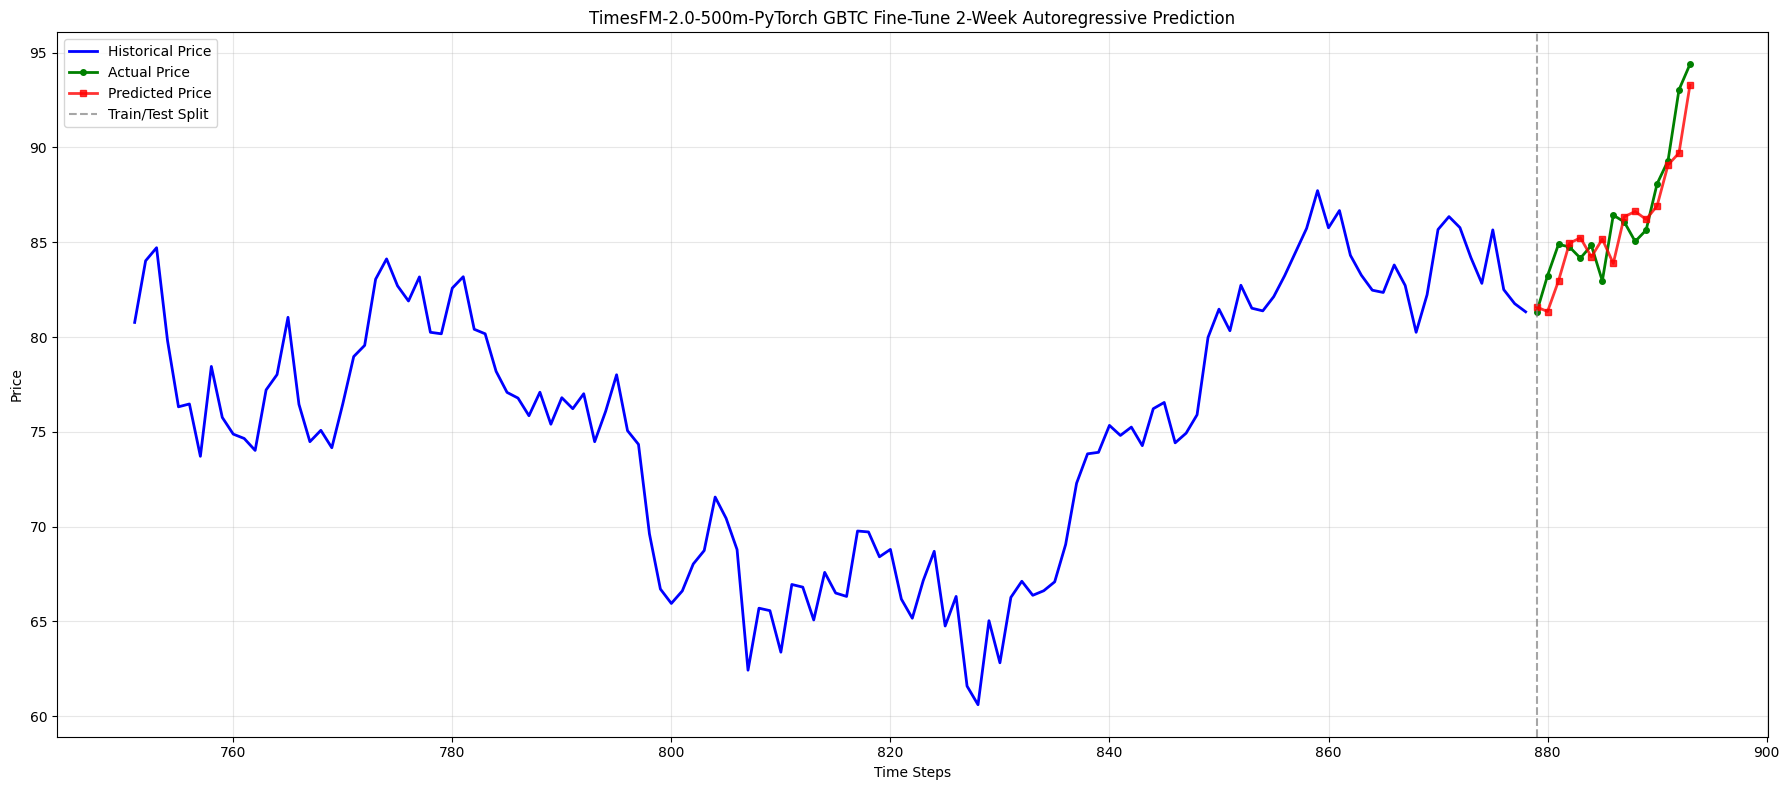

MAE: 1.2652574869791673


In [ ]:
def predict_single_day(model, context_data, real_future_data):
    model.eval()
    device = next(model.parameters()).device

    if len(context_data) < CONFIG['context_length']:
        raise ValueError(f"Need at least {CONFIG['context_length']} data points")

    predictions = []
    current_context = context_data.copy()

    for day in range(CONFIG['days_to_predict']):
        context_window = current_context[-CONFIG['context_length']:].flatten()

        x_context = torch.tensor(context_window, dtype=torch.float32).unsqueeze(0)
        x_padding = torch.zeros_like(x_context)
        freq = torch.tensor([CONFIG['freq_type']], dtype=torch.long).unsqueeze(0)

        x_context = x_context.to(device)
        x_padding = x_padding.to(device)
        freq = freq.to(device)

        with torch.no_grad():
            model_predictions = model(x_context, x_padding.float(), freq)
            predictions_mean = model_predictions[..., 0]
            forecast = predictions_mean[0, -1, :].cpu().numpy()
            next_day_prediction = forecast[0]

        predictions.append(next_day_prediction)

        if day < len(real_future_data):
            actual_next_value = real_future_data[day]
            if hasattr(actual_next_value, 'item'):
                actual_next_value = actual_next_value.item()
            elif isinstance(actual_next_value, np.ndarray):
                actual_next_value = actual_next_value.flatten()[0]
            current_context = np.concatenate([current_context, [[actual_next_value]]])
        else:
            current_context = np.concatenate([current_context, [[next_day_prediction]]])

    return np.array(predictions)

def plot_predictions_comparison(historical_data, predictions, real_future_data):
    plt.figure(figsize=(18, 8))

    context_start = len(historical_data) - CONFIG['context_length']
    plt.plot(range(context_start, len(historical_data)),
             historical_data[context_start:],
             label="Historical Price", color="blue", linewidth=2)

    if len(real_future_data) > 0:
        real_range = range(len(historical_data), len(historical_data) + len(real_future_data))
        plt.plot(real_range, real_future_data,
                 label="Actual Price", color="green", linewidth=2, marker='o', markersize=4)

    pred_range = range(len(historical_data), len(historical_data) + len(predictions))
    plt.plot(pred_range, predictions,
             label="Predicted Price", color="red", linewidth=2,
             marker='s', markersize=4, alpha=0.8)

    plt.axvline(x=len(historical_data), color='gray', linestyle='--', alpha=0.7,
                label="Train/Test Split")

    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.title("TimesFM-2.0-500m-PyTorch GBTC Fine-Tune 2-Week Autoregressive Prediction")
    plt.legend()
    plt.grid(True, alpha=0.3)

    min_len = min(len(predictions), len(real_future_data))
    if min_len > 0:
        errors = np.abs(predictions[:min_len] - real_future_data[:min_len])

    plt.tight_layout()
    plt.savefig("single_day_predictions.png", dpi=300, bbox_inches='tight')
    plt.show()

def main_predictions():
    finetuned_model = MODEL

    df = getDataFrame()
    all_data = getPrice(df).values

    context_data = all_data[:-CONFIG['days_to_predict']].reshape(-1, 1)
    real_future_data = all_data[-CONFIG['days_to_predict']:].reshape(-1, 1)

    predictions = predict_single_day(finetuned_model, context_data, real_future_data)

    plot_predictions_comparison(
        context_data.flatten(), predictions, real_future_data.flatten()
    )

    real_data_flat = real_future_data.flatten()
    mae = np.mean(np.abs(predictions[:len(real_data_flat)] - real_data_flat))
    print("MAE:", mae)

    return predictions, real_future_data

predictions, real_data = main_predictions()

torch.save(MODEL.state_dict(), "pytorch_model.bin")